In [8]:
from utils import read_EHG, read_EMR
import keras
emr = read_EMR.read_EMR('dataset')
ehg = read_EHG.read_EHG('dataset')

g:\Sinh_non\Sinh_non\utils\read_EMR.py:44: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Bleeding_first_trimester']=df['Bleeding_first_trimester'].replace({'yes':1,'no':0})
g:\Sinh_non\Sinh_non\utils\read_EMR.py:45: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Bleeding_second_trimester']=df['Bleeding_second_trimester'].replace({'yes':1,'no':0})
g:\Sinh_non\Sinh_non\utils\read_EMR.py:46: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, expli

In [9]:
import numpy as np
X_ehg = np.array(ehg[-1])
X_emr = np.array(emr[1])
y_binary = np.array(ehg[0])[:, 0]
y_regression = np.array(ehg[0])[:, 1].reshape(-1, 1)

In [10]:
import matplotlib.pyplot as plt

def visualize2(history):
    plt.figure(figsize=(20,12))
    # Accuracy
    plt.subplot(2,2,1)
    plt.plot(history.history['mse'], label='Train MSE')
    plt.plot(history.history['val_mse'], label='Val MSE')
    plt.title('MSE')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()

    # Precision
    plt.subplot(2,2,2)
    plt.plot(history.history['mae'], label='Train Mae')
    plt.plot(history.history['val_mae'], label='Val Mae')
    plt.title('MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [11]:
from sklearn.model_selection import train_test_split

X_ehg_train, X_ehg_test, y_ehg_train, y_ehg_test = train_test_split(X_ehg, y_regression, test_size=0.2, random_state=42)
X_emr_train, X_emr_test, y_emr_train, y_emr_test = train_test_split(X_emr, y_regression, test_size=0.2, random_state=42)

In [12]:
from keras import layers, Model


class TCNBlock(layers.Layer):
    def __init__(self, filters, kernel_size=3, dilation_rate=1, dropout=0.0, name=None):
        super().__init__(name=name)
        self.filters = filters
        self.kernel_size = kernel_size
        self.dilation_rate = dilation_rate
        self.dropout_rate = dropout

        # conv layers (causal padding)
        self.conv1 = layers.Conv1D(filters, kernel_size,
                                   dilation_rate=dilation_rate,
                                   padding="causal",
                                   use_bias=False)
        self.bn1 = layers.BatchNormalization()
        self.act1 = layers.ReLU()
        self.drop1 = layers.Dropout(dropout) if dropout > 0 else None

        self.conv2 = layers.Conv1D(filters, kernel_size,
                                   dilation_rate=dilation_rate,
                                   padding="causal",
                                   use_bias=False)
        self.bn2 = layers.BatchNormalization()
        self.act2 = layers.ReLU()
        self.drop2 = layers.Dropout(dropout) if dropout > 0 else None

        # residual add + final activation
        self.add_layer = layers.Add()
        self.final_act = layers.ReLU()

        # downsample will be created in build() only if needed
        self.downsample = None

    def build(self, input_shape):
        # input_shape: (batch, time, channels_in)
        channels_in = int(input_shape[-1])
        if channels_in != self.filters:
            # create 1x1 conv to match channels
            self.downsample = layers.Conv1D(self.filters, kernel_size=1, padding="same", use_bias=False)
        else:
            # identity function (lambda)
            self.downsample = lambda x: x
        super().build(input_shape)

    def call(self, x, training=None):
        y = self.conv1(x)
        y = self.bn1(y, training=training)
        y = self.act1(y)
        if self.drop1 is not None:
            y = self.drop1(y, training=training)

        y = self.conv2(y)
        y = self.bn2(y, training=training)
        y = self.act2(y)
        if self.drop2 is not None:
            y = self.drop2(y, training=training)

        # residual path: downsample(x) if needed, else identity
        res = self.downsample(x)  # either a Layer or a lambda identity

        out = self.add_layer([res, y])
        return self.final_act(out)


class MultiInputModelTCN(Model):
    def __init__(self):
        super().__init__()

        # TCN branch for time series
        self.tcn1 = TCNBlock(filters=8, kernel_size=3, dilation_rate=1, dropout=0.1)
        self.tcn2 = TCNBlock(filters=16, kernel_size=3, dilation_rate=2, dropout=0.1)
        self.global_pool = layers.GlobalAveragePooling1D()
        self.ts_dense = layers.Dense(16, activation="relu")

        # Tabular branch (MLP)
        self.tab_dense1 = layers.Dense(32, activation="relu")
        self.tab_dense2 = layers.Dense(16, activation="relu")

        # Combined MLP
        self.concat = layers.Concatenate()
        self.fc1 = layers.Dense(16, activation="relu")
        self.fc2 = layers.Dense(8, activation="relu")
        self.out = layers.Dense(1, activation=None)

    def call(self, inputs, training=None):
        ts_input, tab_input = inputs

        # TCN branch
        x1 = self.tcn1(ts_input, training=training)
        x1 = self.tcn2(x1, training=training)
        x1 = self.global_pool(x1)   # -> (batch, channels)
        x1 = self.ts_dense(x1)

        # Tabular branch
        x2 = self.tab_dense1(tab_input)
        x2 = self.tab_dense2(x2)

        # Combine
        x = self.concat([x1, x2])
        x = self.fc1(x)
        x = self.fc2(x)
        return self.out(x)
    
    def build(self, input_shape):
        super().build(input_shape)


In [13]:
import tensorflow as tf
from keras.callbacks import LearningRateScheduler, Callback

# Hàm scheduler
def scheduler(epoch, lr):
    if epoch > 0 and epoch % 5 == 0:
        return lr * 0.8
    return lr

# Callback để log lr mỗi epoch
class LrLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr_obj = self.model.optimizer.learning_rate
        if hasattr(lr_obj, 'numpy'):
            lr = float(lr_obj.numpy())
        else:
            lr = float(tf.keras.backend.get_value(lr_obj))
        print(f"Epoch {epoch+1}: lr = {lr:.6f}")

lr_callback = LearningRateScheduler(scheduler, verbose=1)
log_callback = LrLogger()

In [14]:
model = MultiInputModelTCN()
model.compile(
    optimizer= keras.optimizers.Adam(0.001),
    loss="mse",        
    metrics=["mae", "mse"]
)

In [15]:
import numpy as np

# Flatten nhãn thành 1 chiều
y_flat = y_ehg_train.flatten()

# Chia thành 10 bin
hist, bins = np.histogram(y_flat, bins=10)
bin_indices = np.digitize(y_flat, bins)
bin_indices = np.clip(bin_indices, 1, len(hist))

# Tạo sample weights
weights = 1.0 / hist[bin_indices - 1]
weights /= np.mean(weights)  # chuẩn hóa cho ổn định


history = model.fit(
    [X_ehg_train, X_emr_train],
    y_ehg_train,
    batch_size=32,
    validation_data = ([X_ehg_test, X_emr_test], y_ehg_test),
    epochs=200,
    # sample_weight=weights
    # callbacks=[lr_callback, log_callback]
)

Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - loss: 74750.0156 - mae: 272.8689 - mse: 74750.0156 - val_loss: 73252.0938 - val_mae: 270.0915 - val_mse: 73252.0938
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 73722.2188 - mae: 270.9708 - mse: 73722.2188 - val_loss: 72526.3281 - val_mae: 268.7552 - val_mse: 72526.3281
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 73202.5781 - mae: 270.0143 - mse: 73202.5781 - val_loss: 72169.0781 - val_mae: 268.0908 - val_mse: 72169.0781
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 72843.5938 - mae: 269.3455 - mse: 72843.5938 - val_loss: 71694.4375 - val_mae: 267.2001 - val_mse: 71694.4375
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 72419.6641 - mae: 268.5583 - mse: 72419.6641 - val_loss: 71288.4141 - val_mae: 266.4355 - val_mse: 71288.4141
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 72206.2344 - mae: 268.1561 - mse: 72206.2344 - val_loss: 70964.5547 - val_mae: 265.8251 - val_mse: 709

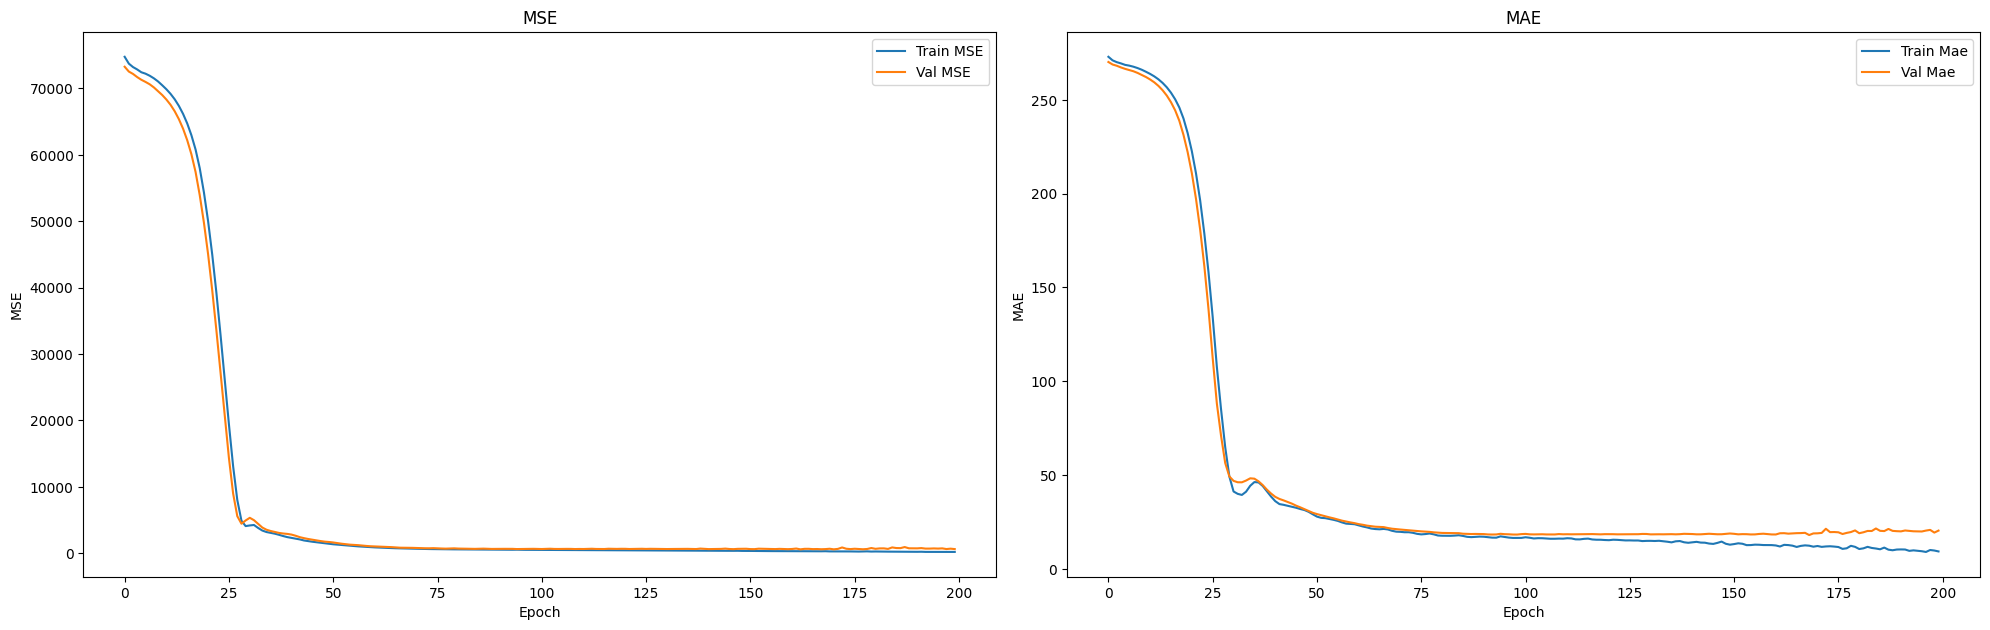

In [16]:
visualize2(history= history)

## LSTM

In [17]:
from keras import layers, Model
class BiLSTMBlock(layers.Layer):
    def __init__(self, units, dropout=0.0, return_sequences=True, name=None):
        super().__init__(name=name)
        self.units = units
        self.dropout_rate = dropout
        self.return_sequences = return_sequences

        # Bidirectional wrapper
        self.bilstm = layers.Bidirectional(
            layers.LSTM(units, dropout=dropout, return_sequences=return_sequences)
        )
        self.act = layers.ReLU()

    def call(self, x, training=None):
        y = self.bilstm(x, training=training)
        y = self.act(y)
        return y


class MultiInputModelLSTM(Model):
    def __init__(self, num_classes=5):
        super().__init__()

        # ======== BiLSTM branch for time series ========
        self.bilstm1 = BiLSTMBlock(units=32, dropout=0.1, return_sequences=True)
        self.bilstm2 = BiLSTMBlock(units=16, dropout=0.2, return_sequences=False)
        self.ts_dense = layers.Dense(16, activation="relu")

        # ======== Tabular branch (MLP) ========
        self.tab_dense1 = layers.Dense(32, activation="relu")
        self.tab_dense2 = layers.Dense(16, activation="relu")

        # ======== Combined MLP ========
        self.concat = layers.Concatenate()
        self.fc1 = layers.Dense(16, activation="relu")
        self.fc2 = layers.Dense(8, activation="relu")
        self.out = layers.Dense(1, activation=None)

    def call(self, inputs, training=None):
        ts_input, tab_input = inputs

        # --- Time series branch (BiLSTM) ---
        x1 = self.bilstm1(ts_input, training=training)
        x1 = self.bilstm2(x1, training=training)
        x1 = self.ts_dense(x1)

        # --- Tabular branch ---
        x2 = self.tab_dense1(tab_input)
        x2 = self.tab_dense2(x2)

        # --- Combine two branches ---
        x = self.concat([x1, x2])
        x = self.fc1(x)
        x = self.fc2(x)
        return self.out(x)

    def build(self, input_shape):
        super().build(input_shape)


In [18]:
model = MultiInputModelLSTM(1)
model.compile(
    optimizer= keras.optimizers.Adam(0.001),
    loss="mse",        
    metrics=["mae", "mse"]
)

In [19]:
history = model.fit(
    [X_ehg_train, X_emr_train],
    y_ehg_train,
    batch_size=32,
    validation_data = ([X_ehg_test, X_emr_test], y_ehg_test),
    epochs=100,
    # callbacks=[lr_callback, log_callback]
)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - loss: 69301.7969 - mae: 262.6893 - mse: 69301.7969 - val_loss: 67808.2656 - val_mae: 259.8273 - val_mse: 67808.2656
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 68282.4766 - mae: 260.7434 - mse: 68282.4766 - val_loss: 66804.6016 - val_mae: 257.8900 - val_mse: 66804.6016
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 67305.4922 - mae: 258.8661 - mse: 67305.4922 - val_loss: 65830.9062 - val_mae: 255.9954 - val_mse: 65830.9062
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 66349.4297 - mae: 257.0097 - mse: 66349.4297 - val_loss: 64941.7695 - val_mae: 254.2512 - val_mse: 64941.7695
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 65428.4492 - mae: 255.2106 - mse: 65428.4492 - val_loss: 63932.0352 - val_mae: 252.2563 - val_mse: 63932.0352
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 64399.6016 - mae: 253.1930 - mse: 64399.6016 - val_loss: 62855.1953 - val_mae: 250.1097 - val_mse: 62

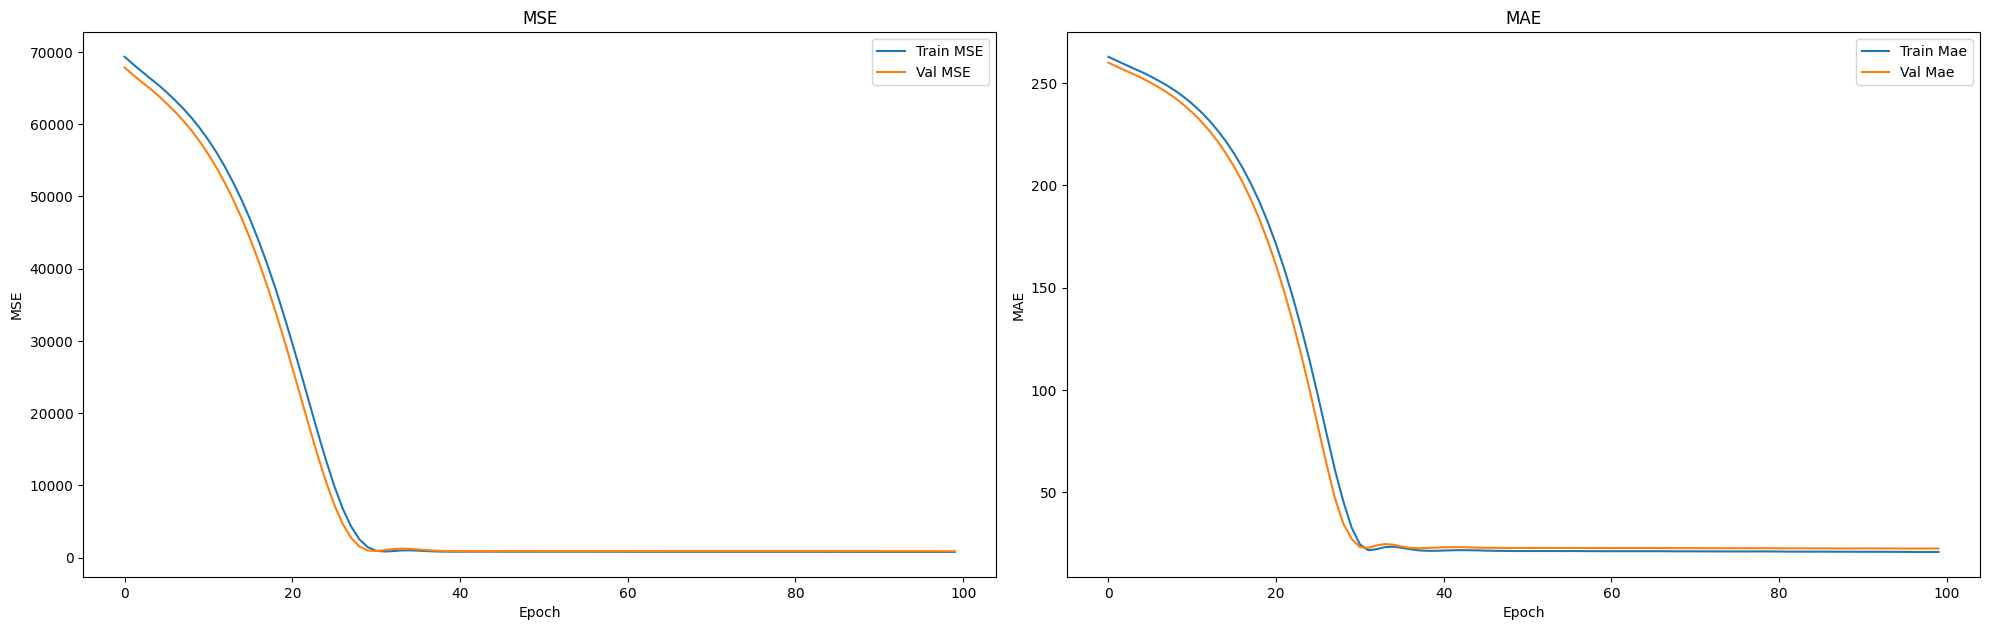

In [20]:
visualize2(history= history)